# Minimizing the Negative Log Likelihood Fit to Retrieve Neutrino Oscillation Parameters From Simulated T2K Data

In [1]:
'''
Importing the required libraries
run this cell twice to prevent inline plotting, and to force plots in a separate window - recommended
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator
from matplotlib import style
style.use('ggplot')
%matplotlib qt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.optimize import minimize
from random import random
from tqdm import tqdm_notebook as tqdm
from copy import deepcopy
from scipy import constants
from scipy import optimize
from timeit import default_timer as timer
from matrix_methods import inverse #importing matrix methods code from assignment
import os
import glob

3.1: Exploring Data

In [2]:
'''
Importing data. Data split into two files - data_to_fit.txt contains first half of data, unoscillated_flux.txt contains
2nd half of data
'''
data_to_fit = pd.read_csv('data_to_fit.txt')
data_to_fit = np.array(data_to_fit).flatten()
unoscillated_flux = pd.read_csv('unoscillated_flux.txt')
unoscillated_flux = np.array(unoscillated_flux).flatten()

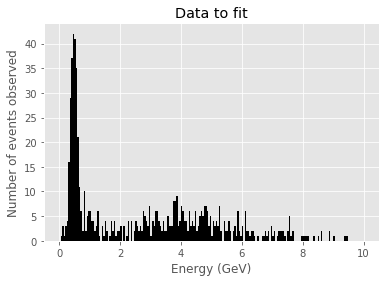

In [3]:
#Plotting observed number of muon events as a histogram.

bins = np.arange(0,10.05,0.05)
plt.hist(bins[:-1],bins,weights = data_to_fit,color = 'k')
plt.title('Data to fit')
plt.xlabel('Energy (GeV)')
plt.ylabel('Number of events observed')
plt.show()

3.2: Creating the fit function

In [4]:
def oscillation_prob(E, mixing_angle = np.pi/4, squared_mass_diff = 2.4e-3, L = 295):
    '''
    function to calculate the probability of a muon neutrino not oscillating
    '''
    if mixing_angle == None:  #setting default values. Nonetype used later on and needed to be handled explicitly
        mixing_angle = np.pi/4
    
    if squared_mass_diff == None:  #setting default values. Nonetype used later on and needed to be handled explicitly
        squared_mass_diff = 2.4e-3
        
    return 1-((np.sin(2*mixing_angle))**2)*(np.sin(1.267*squared_mass_diff*L/E))**2

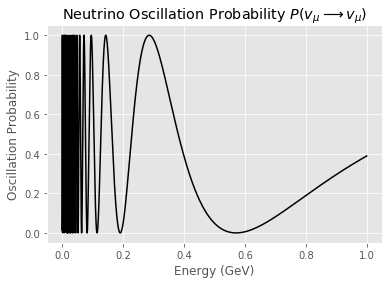

In [5]:
#Plotting oscillation probability as a function of energy

E = np.linspace(0.00001,1,10000)
plt.xlabel('Energy (GeV)')
plt.ylabel('Oscillation Probability')
plt.title(r'Neutrino Oscillation Probability $P\left(v_{\mu} \longrightarrow v_{\mu}\right)$')
plt.plot(E,oscillation_prob(mixing_angle = np.pi/4, squared_mass_diff = 2.4e-3, L = 295, E = E),color = 'k')
plt.show()

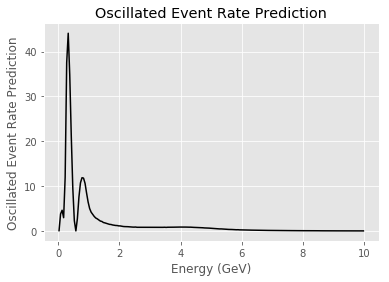

In [6]:
'''
Plotting scillated event prediction rate = oscillation probability*unoscillated flux.
Energy was taken to be bin midpoint
'''

plt.xlabel('Energy (GeV)')
plt.ylabel('Oscillated Event Rate Prediction')
plt.title('Oscillated Event Rate Prediction')
plt.plot(np.arange(0.025,10.025,0.05),oscillation_prob(mixing_angle = np.pi/4, squared_mass_diff = 2.4e-3, L = 295, E = np.arange(0.025,10.025,0.05))*unoscillated_flux,c = 'k')
plt.show()

In [7]:
def cross_section(rate):
    '''
    Function to implement a linearly increasing cross-section as a function of energy.
    '''
    if rate > 0:
        E = np.arange(0.025,10.025,0.05)
        return rate*E
    else:
        raise Exception('Non-positive rate entered. Hypothesis assumes linearly incresing cross-section. Enter positive rate of increase')

In [8]:
def lamda(angle, diff, rate):
    '''
    Function to implement oscillated event rate prediction
    '''
    
    E = np.arange(0.025,10.025,0.05)  #bin midpoints

    if rate == None:  #cross section only accounted for in the later stages. If cross section is Nonetype, treat it as a constant as a function of energy
        return oscillation_prob(mixing_angle = angle, squared_mass_diff = diff, L = 295, E = E)*unoscillated_flux
    else:  #account for cross section if parameter is called
        return oscillation_prob(mixing_angle = angle, squared_mass_diff = diff, L = 295, E = E)*unoscillated_flux*cross_section(rate)

3.3: Negative Log Likelihood (NLL) function

In [9]:
def NLL(mixing_angle = np.pi/4,squared_mass_diff = 2.4e-3, rate = None):
    '''
    Function to implement NLL. Parameters taken: mixing_angle = pi/4 by default and squared_mass_diff = 2.4e-3 by default.
    If rate is not entered, consider cross section to be constant as a function of energy
    '''
    k = data_to_fit
    nll = [] #list of nlls evaluated at each parameter value
    
    for angle in np.array(mixing_angle).ravel():  #cycle through all mixing angles entered. angle defined as an array to account if a float is entered
        for diff in np.array(squared_mass_diff).ravel():  #cycle through all mass differences, similar to angle
            for r in np.array(rate).ravel(): #cycle through rates if rate passed
                lamda_val = lamda(angle,diff,r)  #oscillated event rate prediction at each angle, mass diff and rate
                _ = []  #placeholder list. Used to calculate the sum

                for i in range(len(k)):  #sum over each of the 200 bins
                    
                    if lamda_val[i] > 0 :  #lambda = 0 causes infinities to appear. Can be ignored if 0
                        
                        if k[i] != 0:  #typical case
                            _.append(lamda_val[i] - k[i] + k[i]*np.log(k[i]/lamda_val[i]))
                        if k[i] == 0:  #limit of xlog(x) when x tends to 0 is 0
                            _.append(lamda_val[i])
                            
                nll.append(sum(_))
    
    if len(nll) == 1:
        return np.array(nll).ravel()[0]  #return single value if single values entered for parameters
    else:
        return np.array(nll).ravel()  #return array of nll values

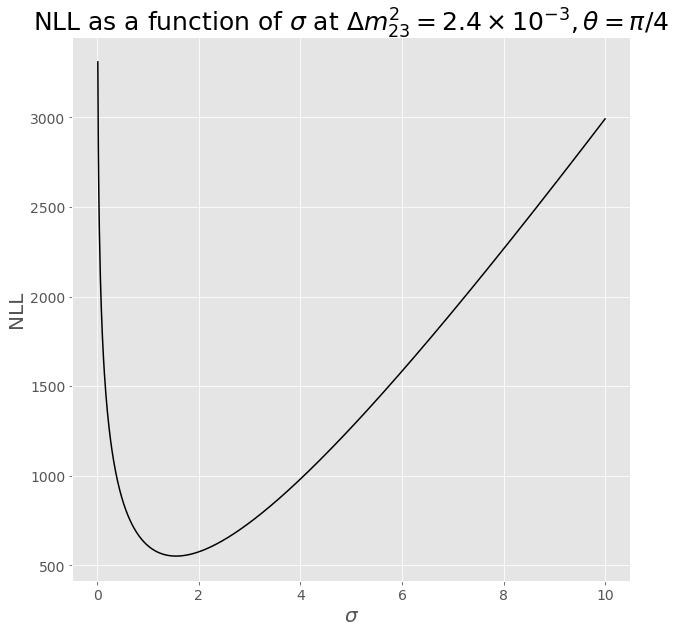

In [10]:
'''
Plotting NLL as a function of rate of cross-section increase
'''
#generic plotting routine
rate = np.linspace(0.01,10,1000)
plt.figure(figsize = (10,10))
plt.plot(rate,NLL(mixing_angle = np.pi/4, squared_mass_diff = 2.4e-3, rate = rate),c = 'k')
plt.xlabel(r'$\sigma$', fontsize = 20)
plt.ylabel('NLL', fontsize = 20)
plt.title(r'NLL as a function of $\sigma$ at $\Delta m_{23}^2 = 2.4 \times 10^{-3}, \theta = \pi/4$',fontsize = 25)
plt.savefig('NLL vs sigma.png', dpi = 800)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

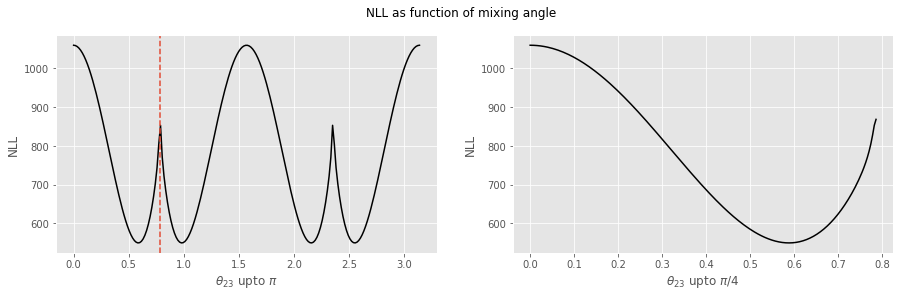

In [11]:
'''
Plotting NLL as a function of mixing angle
'''
#generic plotting routine
fig,axs = plt.subplots(1,2,figsize = (15,4))

theta_1 = np.linspace(0,np.pi,200)
theta_2 = np.linspace(0,np.pi/4,200)

axs[0].plot(theta_1,NLL(mixing_angle = theta_1),c = 'k')
axs[0].axvline(x=np.pi/4,linestyle = '--')
axs[1].plot(theta_2,NLL(mixing_angle = theta_2),c = 'k')

axs[0].set(xlabel=r'$\theta_{23}$ upto $\pi$',ylabel = 'NLL')
axs[1].set(xlabel=r'$\theta_{23}$ upto $\pi/4$',ylabel = 'NLL')  #observed that NLL peaks at pi/4, this will be the upper bound for first cycle 

fig.suptitle('NLL as function of mixing angle')
plt.show()

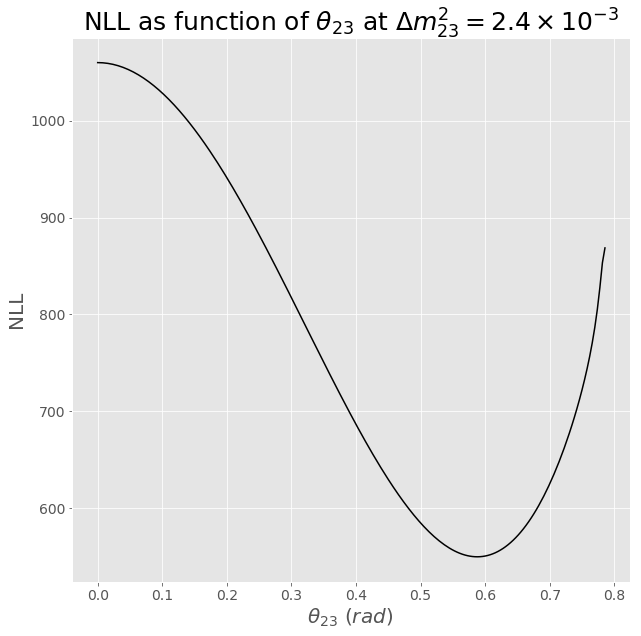

In [12]:
'''
Plotting NLL vs mixing angle (generating figures for report)

'''
#generic plotting routine
plt.figure(figsize = (10,10))
plt.plot(theta_2,NLL(mixing_angle = theta_2),c = 'k')
plt.xlabel(r'$\theta_{23} \ (rad)$ ',fontsize = 20)
plt.ylabel('NLL', fontsize = 20)
plt.title(r'NLL as function of $\theta_{23}$ at $\Delta m_{23}^2 = 2.4 \times 10^{-3}$', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.savefig('NLL vs mixing angle.png', dpi = 800)

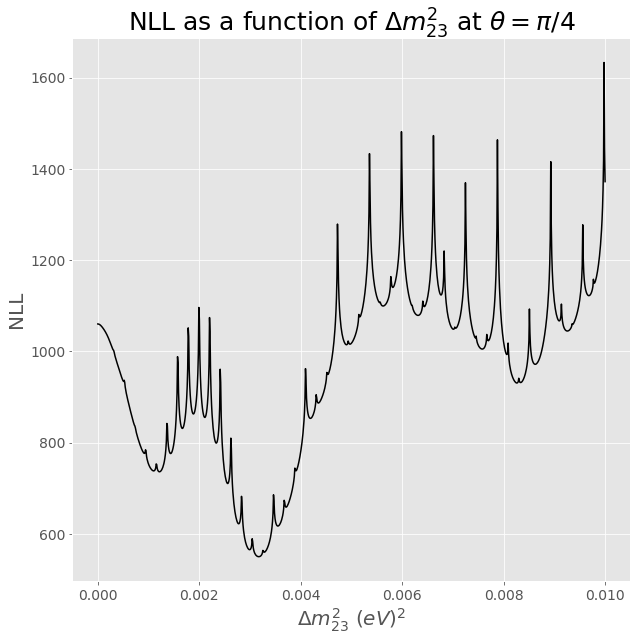

In [13]:
'''
Plotting NLL vs squared mass difference
'''
#generic plotting routine
mass = np.linspace(0,0.01,1000)
plt.figure(figsize = (10,10))
plt.plot(mass,NLL(mixing_angle = np.pi/4, squared_mass_diff = mass),c = 'k')
plt.xlabel(r'$\Delta m_{23}^2 \ (eV)^2$', fontsize = 20)
plt.ylabel('NLL', fontsize = 20)
plt.title(r'NLL as a function of $\Delta m_{23}^2$ at $\theta = \pi/4$', fontsize = 25)
plt.savefig('NLL vs mass diff.png',dpi = 800)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [14]:
def error_from_curvature(optima):
    '''
    Function to implement obtaining the uncertainties on optimized parameters of the NLL using finite difference schemes.
    Details of mathematics included in report. optima = array of parameters at which uncertainities are to be calculated.
    '''
    
    h = 1e-3  #step size. Too small a step and the errors will diverge
    optima = np.array(optima).ravel()  #preparing the input array
    
    if len(optima) == 3:  #dealing with 3 parameters - when cross-section is considered
        
        a, b, c = optima[0], optima[1], optima[2]
        
        def second_derv(a, b, c, h, keys):  #calculate the hessian matrix according to finite difference scheme

            key_1 = keys[0]  #keys determine which derivative populates which position in the matrix
            key_2 = keys[1]

            if key_1 == key_2: #diagonal elements treated separately           
                if key_1 == 'angle':
                    return ((NLL(a + h, b, c) - (2*NLL(a, b, c)) + NLL(a-h,b,c))/(h**2))
                if key_1 == 'mass':
                    return ((NLL(a, b+h, c) - (2*NLL(a, b, c)) + NLL(a,b-h,c))/(h**2))
                if key_1 == 'rate':
                    return ((NLL(a, b, c+h) - (2*NLL(a, b, c)) + NLL(a,b,c-h))/(h**2))
            else:  #non-diagonal elements treated separately
                if key_1 == 'angle' and key_2 == 'mass' or key_1 == 'mass' and key_2 == 'angle':
                    return (NLL(a+h,b+h,c) - NLL(a+h,b-h,c) - NLL(a-h,b+h,c) + NLL(a-h,b-h,c))/(4*h**2)
                if key_1 == 'angle' and key_2 == 'rate' or key_1 == 'rate' and key_2 == 'angle':
                    return (NLL(a+h,b,c+h) - NLL(a+h,b,c-h) - NLL(a-h,b,c+h) + NLL(a-h,b,c-h))/(4*h**2)
                if key_1 == 'mass' and key_2 == 'rate' or key_1 == 'rate' and key_2 == 'mass':
                    return (NLL(a,b+h,c+h) - NLL(a,b+h,c-h) - NLL(a,b-h,c+h) + NLL(a,b-h,c-h))/(4*h**2)


        W = np.zeros((3,3))
        keys = ['angle', 'mass', 'rate']

        for i in range(3):  #populate W - the hessian
            for j in range(3):
                W[i,j] = second_derv(a,b,c,h,[keys[i],keys[j]])

        E = inverse(W)  #invert W using forward-back substituion as done for the assignment. Refer to matrix_methods.py
        err = np.zeros((1,3)).ravel()  #array containing errors
        for i in range(3):  #populate err
            err[i] = np.sqrt(E[i,i])
        return err
    
    elif len(optima) == 2:  #dealing with 2 parameters - when cross-section is taken to be a constant of 1
        
        a, b = optima[0], optima[1]
        
        def second_derv(a, b, h, keys):  #description similar to 3 parameter case

            key_1 = keys[0]
            key_2 = keys[1]

            if key_1 == key_2:            
                if key_1 == 'angle':
                    return ((NLL(a + h, b) - (2*NLL(a, b)) + NLL(a-h,b))/(h**2))
                if key_1 == 'mass':
                    return ((NLL(a, squared_mass_diff=b+h) - (2*NLL(a, squared_mass_diff=b)) + NLL(a,squared_mass_diff=b-h))/(h**2))
            else:
                return (NLL(a+h,b+h) - NLL(a+h,b-h) - NLL(a-h,b+h) + NLL(a-h,b-h))/(4*h**2)
                

        W = np.zeros((2,2))
        keys = ['angle', 'mass']

        for i in range(2):
            for j in range(2):
                W[i,j] = second_derv(a,b,h,[keys[i],keys[j]])

        E = inverse(W)
        err = np.zeros((1,2)).ravel()
        for i in range(2):
            err[i] = np.sqrt(E[i,i])
        return err
    
    else:
        raise Exception('Enter 2 or 3 points at which error is to be calculated.')

In [15]:
def parabolic_minimiser(x,function,key,mixing_angle = None,squared_mass_diff = None,plot = False,error = False):
    
    '''
    Function to implement 1d parabolic minimization. x = initial 3 points, function = function to be minimized,
    mixing_angle and squared_mass_diff for argument passing into NLL if function = NLL, plot = True then plotting routine is run,
    error = True then error using the parabolic estimate around the minimum ± 0.5 is calculated.
    x is required to be such that at least one element of x ie 1 of 3 points, is on either side of the minimum - 2 on left of min, 1 on right. Or 1 on left and 2 on right
    '''
    
    def NLL_std(minimum, a, b, c, key):
        '''
        Function to calculate standard deviation ie error from min NLL ± 0.5.
        '''
        
        if key == 'angle':  #NLL parameters to be entered dependending on the key
            
            y_std = function(mixing_angle = minimum, squared_mass_diff = squared_mass_diff) + 0.5
            x1 = (-b + np.sqrt((b**2) - (4*a*(c - y_std))))/(2*a)
            x2 = (-b - np.sqrt((b**2) - (4*a*(c - y_std))))/(2*a) #solving the quadratic equation for when NLL changes by 0.5
            std1 = abs(minimum - x1)
            std2 = abs(minimum - x2)
            
            return np.array([std1,std2])
        
        if key == 'mass':
            
            y_std = function(mixing_angle = mixing_angle, squared_mass_diff = minimum) + 0.5
            x1 = (-b + np.sqrt((b**2) - (4*a*(c - y_std))))/(2*a)
            x2 = (-b - np.sqrt((b**2) - (4*a*(c - y_std))))/(2*a) #solving the quadratic equation for when NLL changes by 0.5
            std1 = abs(minimum - x1)
            std2 = abs(minimum - x2)
                  
            return np.array([std1,std2])
    
    
    if key == 'angle':  #key allows for NLL parameters to be handled appropriately. Notice the difference in "function()" for different keys
                  
        def minimise(x,y):

            num = ((x[2]**2 - x[1]**2)*y[0]) + ((x[0]**2 - x[2]**2)*y[1]) + ((x[1]**2 - x[0]**2)*y[2])
            denom = ((x[2] - x[1])*y[0]) + ((x[0] - x[2])*y[1]) + ((x[1] - x[0])*y[2])

            x3 = 0.5*num/denom  #calculate 2nd order lagrange polynomial

            _ = {x[0] : y[0], x[1] : y[1], x[2] : y[2], x3 : function(mixing_angle=x3,squared_mass_diff=squared_mass_diff)}  #sort dictionary based on the values of the function at those x values
            sorted_ = sorted(_.items(), key=operator.itemgetter(1))
            new_x = np.array([sorted_[i][0] for i in range(len(sorted_))][:-1]).flatten()  #x values at the lowest 3 function values at these xs is needed for parabolic method to progress - allows for convergence

            a = y[0]*(1/((x[0] - x[1])*(x[0] - x[2])))+ y[1]*(1/((x[1] - x[0])*(x[1] - x[2]))) + y[2]*(1/((x[2] - x[0])*(x[2] - x[1])))  #coefficients of the parabola - needed to estimate the uncertainties
            b = y[0]*(-x[2]-x[1])/((x[0]-x[1])*(x[0]-x[2])) + y[1]*(-x[2]-x[0])/((x[1]-x[0])*(x[1]-x[2])) + y[2]*(-x[1]-x[0])/((x[2]-x[0])*(x[2]-x[1]))
            c = y[0]*(x[1]*x[2])/((x[0]-x[1])*(x[0]-x[2])) + y[1]*(x[0]*x[2])/((x[1]-x[0])*(x[1]-x[2])) + y[2]*(x[0]*x[1])/((x[2]-x[0])*(x[2]-x[1]))

            return np.array([x3, new_x, a, b, c])

        x_ = []  #placeholder list for x values of minimum - history array
        y_ = []  #placeholder list for y values of minimum - history array

        old_min = minimise(x,function(mixing_angle = x,squared_mass_diff = squared_mass_diff))  #start parabolic method
        new_min = minimise(old_min[1],function(mixing_angle = old_min[1], squared_mass_diff = squared_mass_diff))  #perform one more iteration so that while loop criteria is defined before calling
        
        x_.append(old_min[0])
        x_.append(new_min[0])
        y_.append(function(mixing_angle = old_min[0] ,squared_mass_diff = squared_mass_diff))
        y_.append(function(mixing_angle = new_min[0],squared_mass_diff = squared_mass_diff))

        while abs(new_min[0] - old_min[0]) > 1e-8:  #method converges when the difference between last minimum and current minimum is less than 1e-8

            old_min = minimise(new_min[1],function(mixing_angle = new_min[1], squared_mass_diff = squared_mass_diff))
            new_min = minimise(old_min[1],function(mixing_angle = old_min[1], squared_mass_diff = squared_mass_diff))

            x_.append(old_min[0])
            x_.append(new_min[0])
            y_.append(function(mixing_angle = old_min[0],squared_mass_diff = squared_mass_diff))
            y_.append(function(mixing_angle = new_min[0],squared_mass_diff = squared_mass_diff))
        
        p = new_min[2] #a coefficient
        q = new_min[3] #b coefficient
        r = new_min[4] #c coefficient
        
        if plot:
            #plotting routine
            plt.figure(figsize = (10,10))
            plt.plot(x_[-1],y_[-1],'rx',label = 'minima')
            theta_2 = np.linspace(0,np.pi/4,1000)
            plt.plot(theta_2,NLL(mixing_angle = theta_2),c = 'k',label = 'NLL vs mixing angle')
            if error:  #plotting NLL ± error for report
                error_std = NLL_std(new_min[0],p,q,r, key = 'angle')
                plt.plot(x_[-1]+error_std[0],NLL(mixing_angle = x_[-1]+error_std[0]), 'bo', label = 'parabolic error')
                plt.plot(x_[-1]-error_std[1],NLL(mixing_angle = x_[-1]-error_std[1]), 'bo')
                plt.plot(x_[-1]+0.013071565829121685,NLL(mixing_angle = x_[-1]+0.013071565829121685), 'g*', label = 'curvature error')
                plt.plot(x_[-1]-0.013071565829121685,NLL(mixing_angle = x_[-1]-0.013071565829121685), 'g*')
            plt.xlabel(r'$\theta_{23} \ (rad)$', fontsize = 20)
            plt.ylabel(r'NLL', fontsize = 20)
            plt.title(r'$\hat{\theta}_{23}$ found by parabolic method', fontsize = 25)
            plt.legend()
            plt.xlim(0.573,0.6017)
            plt.ylim(548,552)
            plt.xticks(fontsize = 14)
            plt.yticks(fontsize = 14)
            plt.savefig('theta min parabolic.png',dpi = 800)
            
        if error: #return error if needed
            return new_min[0], np.array(x_).ravel(), np.array(y_).ravel(), np.array([p,q,r]), NLL_std(new_min[0],p,q,r, key = 'angle')
        else:
            return new_min[0], np.array(x_).ravel(), np.array(y_).ravel(), np.array([p,q,r])
        
    if key == 'mass':  #similar to above, except minimising in the mass direction
        
        def minimise(x,y):

            num = ((x[2]**2 - x[1]**2)*y[0]) + ((x[0]**2 - x[2]**2)*y[1]) + ((x[1]**2 - x[0]**2)*y[2])
            denom = ((x[2] - x[1])*y[0]) + ((x[0] - x[2])*y[1]) + ((x[1] - x[0])*y[2])

            x3 = 0.5*num/denom

            _ = {x[0] : y[0], x[1] : y[1], x[2] : y[2], x3 : function(mixing_angle=mixing_angle,squared_mass_diff=x3)}  #key needed due to the way NLL has been defined
            sorted_ = sorted(_.items(), key=operator.itemgetter(1))
            new_x = np.array([sorted_[i][0] for i in range(len(sorted_))][:-1]).flatten()

            a = y[0]*(1/((x[0] - x[1])*(x[0] - x[2])))+ y[1]*(1/((x[1] - x[0])*(x[1] - x[2]))) + y[2]*(1/((x[2] - x[0])*(x[2] - x[1])))
            b = y[0]*(-x[2]-x[1])/((x[0]-x[1])*(x[0]-x[2])) + y[1]*(-x[2]-x[0])/((x[1]-x[0])*(x[1]-x[2])) + y[2]*(-x[1]-x[0])/((x[2]-x[0])*(x[2]-x[1]))
            c = y[0]*(x[1]*x[2])/((x[0]-x[1])*(x[0]-x[2])) + y[1]*(x[0]*x[2])/((x[1]-x[0])*(x[1]-x[2])) + y[2]*(x[0]*x[1])/((x[2]-x[0])*(x[2]-x[1]))


            return np.array([x3, new_x, a, b, c])

        x_ = []
        y_ = []

        old_min = minimise(x,function(mixing_angle = mixing_angle,squared_mass_diff = x))
        new_min = minimise(old_min[1],function(mixing_angle = mixing_angle,squared_mass_diff = old_min[1]))
        
        x_.append(old_min[0])
        x_.append(new_min[0])
        y_.append(function(mixing_angle = mixing_angle ,squared_mass_diff = old_min[0]))
        y_.append(function(mixing_angle = mixing_angle,squared_mass_diff = new_min[0]))


        while abs(new_min[0] - old_min[0]) > 1e-8:

            old_min = minimise(new_min[1],function(mixing_angle = mixing_angle, squared_mass_diff = new_min[1]))
            new_min = minimise(old_min[1],function(mixing_angle = mixing_angle, squared_mass_diff = old_min[1]))
            x_.append(old_min[0])
            x_.append(new_min[0])
            y_.append(function(mixing_angle = mixing_angle,squared_mass_diff = old_min[0]))
            y_.append(function(mixing_angle = mixing_angle,squared_mass_diff = new_min[0]))
 
        p = new_min[2]
        q = new_min[3]
        r = new_min[4]            

        if plot:
            plt.figure(figsize = (10,10))
            plt.plot(x_[-1],y_[-1],'rx',label = 'minima')
            mass = np.linspace(0,0.01,5000)
            plt.plot(mass,NLL(mixing_angle = mixing_angle,squared_mass_diff = mass),c = 'k',label = 'NLL vs squared mass diff')
            if error:
                error_std = NLL_std(new_min[0],p,q,r, key = 'mass')
                plt.plot(x_[-1]+error_std[0],NLL(squared_mass_diff = x_[-1]+error_std[0]), 'bo', label = 'parabolic error')
                plt.plot(x_[-1]-error_std[1],NLL(squared_mass_diff = x_[-1]-error_std[1]), 'bo')
                plt.plot(x_[-1]+6.147705604891163e-05,NLL(squared_mass_diff = x_[-1]+6.147705604891163e-05), 'g*', label = 'curvature error')
                plt.plot(x_[-1]-6.147705604891163e-05,NLL(squared_mass_diff = x_[-1]-6.147705604891163e-05), 'g*')
            plt.legend()
            plt.xlabel(r'$\Delta m_{23}^2 \ (eV)^2$', fontsize = 20)
            plt.ylabel(r'NLL', fontsize = 20)
            plt.title(r'$\hat{\Delta m}_{23}^2$ found by parabolic method', fontsize = 25)
            plt.xticks(fontsize = 14)
            plt.yticks(fontsize = 14)
            plt.xlim(0.003109,0.00324)
            plt.ylim(545,560)
            plt.savefig('mass min parabolic.png', dpi = 800)
        
        if error:
            return new_min[0], np.array(x_).ravel(), np.array(y_).ravel(), np.array([p,q,r]), NLL_std(new_min[0],p,q,r, key = 'mass')
        else:
            return new_min[0], np.array(x_).ravel(), np.array(y_).ravel(), np.array([p,q,r])            

In [ ]:
'''
Plot and print the results of the parabolic minimizer. 
Different error procedures are also shown - parabolic and curvature procedures.
The curvature procedure is better as the hessian encodes direct information of the actual function, while the parabolic procedure,
albeit a very good approximation around the minimum, is still an approximation. Refer to report for details.
'''

theta = np.array([0.3,0.4,0.5])  #initial 3 points of mixing angle
angle_parabolic_min = parabolic_minimiser(theta,NLL,key = 'angle',error = True, plot = True)  #call method
mass = np.array([0.0025,0.0028,0.0035])  #initial 3 points of squared mass diff
mass_parabolic_min = parabolic_minimiser(mass,NLL,key = 'mass', error = True, plot = True)
curvature_error = error_from_curvature([angle_parabolic_min[0],mass_parabolic_min[0]])
print('Value of theta_23 that minimises NLL = ',angle_parabolic_min[0], ' ± ', angle_parabolic_min[-1], '(mean error from parabolic estimate = %s)' %np.mean(angle_parabolic_min[-1]))
print('Value of delta_m_23^2 that minimises NLL = ',mass_parabolic_min[0], ' ± ', mass_parabolic_min[-1],'(mean error from parabolic estimate = %s)' %np.mean(mass_parabolic_min[-1]) )
print('Value of theta_23 that minimises NLL = ',angle_parabolic_min[0], ' ± ', curvature_error[0], '(error from curvature)')
print('Value of delta_m_23^2 that minimises NLL = ',mass_parabolic_min[0], ' ± ', curvature_error[1],'(error from curvature)')
print('NLL min = ', NLL(angle_parabolic_min[0],mass_parabolic_min[0]))

Value of theta_23 that minimises NLL =  0.5876070784053129  ±  [0.00788386 0.0076991 ] (mean error from parabolic estimate = 0.007791480765629133)
Value of delta_m_23^2 that minimises NLL =  0.0031730675736145963  ±  [2.25788645e-05 2.25786470e-05] (mean error from parabolic estimate = 2.257875575826466e-05)
Value of theta_23 that minimises NLL =  0.5876070784053129  ±  0.013071565829121685 (error from curvature)
Value of delta_m_23^2 that minimises NLL =  0.0031730675736145963  ±  6.147705604891163e-05 (error from curvature)
NLL min =  538.0604406919131


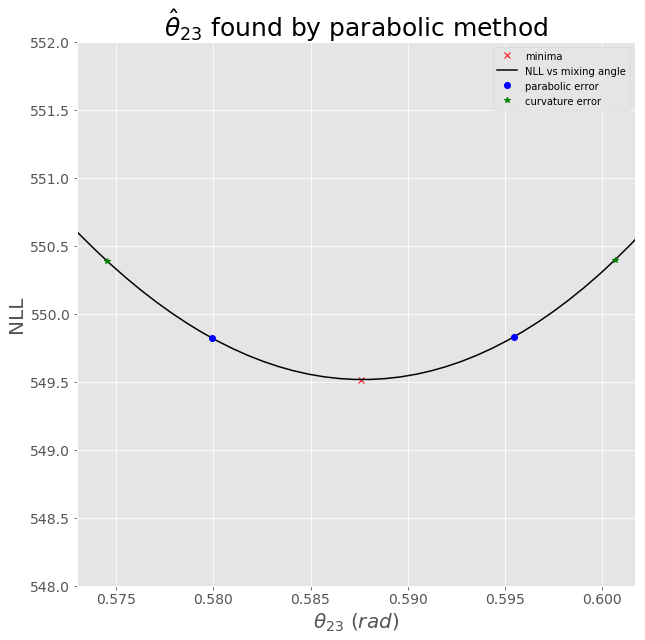

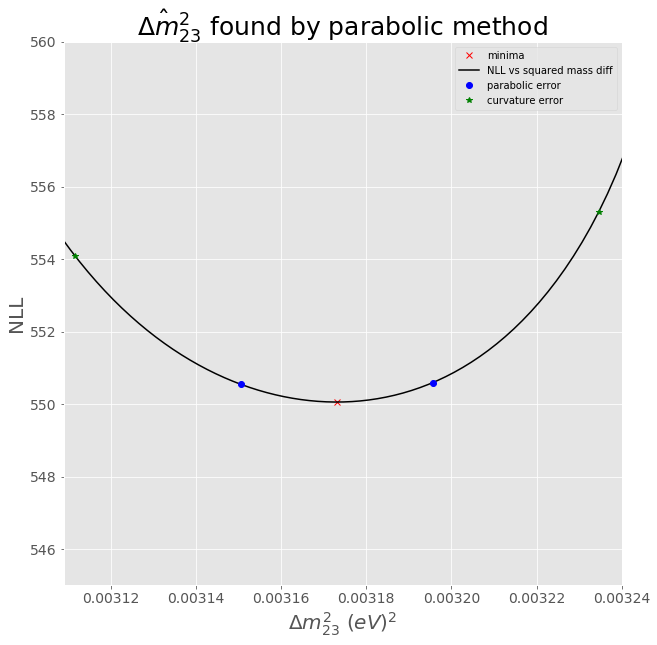

In [16]:
'''
Plot and print the results of the parabolic minimizer. 
Different error procedures are also shown - parabolic and curvature procedures.
The curvature procedure is better as the hessian encodes direct information of the actual function, while the parabolic procedure,
albeit a very good approximation around the minimum, is still an approximation. Refer to report for details.
'''

theta = np.array([0.4,0.5,0.7])  #initial 3 points of mixing angle
angle_parabolic_min = parabolic_minimiser(theta,NLL,key = 'angle',error = True, plot = True)  #call method
mass = np.array([0.0025,0.0028,0.0035])  #initial 3 points of squared mass diff
mass_parabolic_min = parabolic_minimiser(mass,NLL,key = 'mass', error = True, plot = True)
curvature_error = error_from_curvature([angle_parabolic_min[0],mass_parabolic_min[0]])
print('Value of theta_23 that minimises NLL = ',angle_parabolic_min[0], ' ± ', angle_parabolic_min[-1], '(mean error from parabolic estimate = %s)' %np.mean(angle_parabolic_min[-1]))
print('Value of delta_m_23^2 that minimises NLL = ',mass_parabolic_min[0], ' ± ', mass_parabolic_min[-1],'(mean error from parabolic estimate = %s)' %np.mean(mass_parabolic_min[-1]) )
print('Value of theta_23 that minimises NLL = ',angle_parabolic_min[0], ' ± ', curvature_error[0], '(error from curvature)')
print('Value of delta_m_23^2 that minimises NLL = ',mass_parabolic_min[0], ' ± ', curvature_error[1],'(error from curvature)')
print('NLL min = ', NLL(angle_parabolic_min[0],mass_parabolic_min[0]))

In [20]:
'''
Plot showing the goodness of the parabolic approximation around the minimum.
'''

theta_1 = np.linspace(0,np.pi/4,200)
parabolic_min = parabolic_minimiser(theta,NLL,key = 'angle')
plt.figure(figsize = (10,10))
plt.plot(theta_1,NLL(theta_1), label = 'nll')

a,b,c = parabolic_min[-1][0], parabolic_min[-1][1], parabolic_min[-1][2]

def poly(x):
    return (a*(x**2)) + (b*x) + c

plt.plot(theta_1,poly(theta_1), label = 'last parabola')
plt.xlabel('Mixing angle', fontsize = 20)
plt.ylabel('NLL', fontsize = 20)
plt.title('Last parabolic estimate around the minimum', fontsize = 25)
plt.legend()
plt.savefig('last parabola.png',dpi = 800)
plt.show()

In [21]:
def univariate_min(angle,mass,function,plot = False):
    
    '''
    function to implement 2d univariate method - parabolic method applied in successive dimensions, fixing the function at
    the optimum obtained in the previous dimension each time
    angle = initial 3 points for mixing angle - require at least 1 on either side of the minimum
    mass = initial 3 points for squared mass diff - require at least 1 on either side of the minimum
    function specifies the function being minimized - enter NLL
    plot = True: plotting routine will be activated
    
    '''
    
    mass_min = parabolic_minimiser(mass,function,key = 'mass')  #parabolic method in squared mass direction at default mixing angle
    nll_mass_min = NLL(0.7,mass_min[0])  #evaluate nll at this point
    theta_min = parabolic_minimiser(angle,function,squared_mass_diff=mass_min[0],key = 'angle')  #parabolic method in angle direction, fixing squared mass to that just found above
    nll_theta_min = NLL(theta_min[0],mass_min[0])  #evaluate nll at this point
    
    #history of squared masses and mixing angles, required for plotting paths
    mass_mins = [mass_min[0]]  
    theta_mins = [theta_min[0]]
    a = 1e-7  #accuracy - making it smaller will cause the algorithm to 'jump' over minimum - getting stuck in a loop
    
    while abs(nll_mass_min - nll_theta_min) > a:  #converge when the difference between the minimum nll obtained in the previous and that obtained in the current direction is smaller than accuracy
        mass_min = parabolic_minimiser(mass,function,mixing_angle = theta_min[0],key = 'mass')
        mass_mins.append(mass_min[0])
        nll_mass_min = NLL(theta_min[0],mass_min[0])
        theta_min = parabolic_minimiser(angle,function,squared_mass_diff = mass_min[0],key = 'angle')
        theta_mins.append(theta_min[0])
        nll_theta_min = NLL(theta_min[0],mass_min[0])
        
        
        
    x_1 = mass_min[1]
    y_1 = mass_min[2]
    x_2 = theta_min[1]
    y_2 = theta_min[2]
    
    #uncertainties from parabolic procedure
    err_mass = parabolic_minimiser(mass,function,mixing_angle = theta_mins[-2],key = 'mass', error = True)[-1]  #
    err_theta = parabolic_minimiser(angle,function,squared_mass_diff = mass_mins[-2],key = 'angle', error = True)[-1]
    
    
    if plot:
        
        theta = np.linspace(0,np.pi/4,50)
        mass = np.linspace(0,0.01,50)
        X, Y = np.meshgrid(theta, mass)  #create grid to plot surfaces and imshow
        X_ravel = np.ravel(X)
        Y_ravel = np.ravel(Y)
        zs = np.array([NLL(X_ravel[i], Y_ravel[i]) for i in tqdm(range(len(X_ravel)))]).ravel()
        Z = zs.reshape(X.shape)
        fig =  plt.figure(figsize = (10,10))
        ax = fig.gca(projection='3d')
        ax.set_xlabel(r'$\theta_{23} \ (rad)$', fontsize = 20)
        ax.set_ylabel(r'$\Delta m_{23}^2 \ (eV)^2$', fontsize = 20)
        ax.set_zlabel('NLL', fontsize = 20)
        ax.set_title('Position of minimum obtained from univariate method', fontsize = 25)
        ax.scatter(x_2[-1],x_1[-1],y_2[-1],c = 'r', marker = 'x', s = 100, label = 'minimum')  #plot minimum
        surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False,alpha = 0.5)  #plot surface
        plt.legend()
        fig.tight_layout()
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        #imshow range changed to produce plots required for report
        x = np.linspace(0.55,0.75,100)
        y = np.linspace(0.00280,0.0032,100)
        X,Y = np.meshgrid(x,y)
        X_ravel = np.ravel(X)
        Y_ravel = np.ravel(Y)
        zs = np.array([NLL(X_ravel[i], Y_ravel[i]) for i in tqdm(range(len(X_ravel)))]).ravel()
        Z = zs.reshape(X.shape)
        fig1 = plt.figure(figsize=(15,15))
        plt.grid(False)
        extent = [0.55,0.75,0.00280,0.0032]
        plt.imshow(Z,origin = 'lower',cmap = 'ocean', extent = extent,aspect = 'auto', alpha = 0.7)
        cbar = plt.colorbar()
        cbar.set_label('NLL', fontsize = 20)
        plt.xlabel(r'$\theta_{23} \ (rad)$', fontsize = 20)
        plt.ylabel(r'$\Delta m_{23}^2 \ (eV)^2$', fontsize = 20)
        plt.title('2D visualization of the position of the minimum NLL', fontsize = 25)
        plt.scatter(theta_min[0],mass_min[0], marker = 'x', s = 100, c = 'r', label = 'minimum NLL')
        plt.scatter(theta_mins[0],mass_mins[0], marker = 'x',s = 100, c = 'k', label = 'start')
        plt.plot(theta_mins, mass_mins, linestyle = '--', c = 'r', label = 'path')
        levels = np.arange(510,524,2)
        contours = plt.contour(X, Y, Z, levels = levels, colors='black', linestyles = 'dashed')
        plt.clabel(contours, inline=True, fontsize=8)
        plt.legend()
        plt.xticks(fontsize = 15)
        plt.yticks(fontsize = 15)
        fig1.tight_layout()
        plt.savefig('univariate min.png',dpi = 800)


    return mass_min[0], err_mass, theta_min[0], err_theta  #return optimum values at minimum and their parabolic errors

In [22]:
'''
Run univariate method, produce plots, print results obtained
'''

angle = np.array([0.4,0.5,0.7])  #initial 3 points
mass = np.array([0.0025,0.0028,0.0035])  #initial 3 points
minimum = univariate_min(angle,mass,NLL, plot = True)
curvature_error = error_from_curvature([minimum[2],minimum[0]])
print('mixing angle = ', minimum[2], ' ± ', minimum[3], '(mean error = %s)' %np.mean(minimum[3]))  #mean just for reference, two sided error required
print('squared mass diff = ', minimum[0], ' ± ', minimum[1], '(mean error = %s)' %np.mean(minimum[1]))
print('mixing angle = ', minimum[2], ' ± ', curvature_error[0], '(error from curvature)')  #curvature error for reference and comparison for report
print('squared mass diff = ', minimum[0], ' ± ', curvature_error[1], '(error from curvature)')
print('NLL min = ', NLL(minimum[2],minimum[0]))  #smaller nll than that by parabolic method


mixing angle =  0.6372469012600144  ±  [0.01146392 0.01133661] (mean error = 0.011400267322618785)
squared mass diff =  0.002907674301928171  ±  [5.21300686e-05 5.21433997e-05] (mean error = 5.213673412989418e-05)
mixing angle =  0.6372469012600144  ±  0.01167536839907987 (error from curvature)
squared mass diff =  0.002907674301928171  ±  5.915843099866156e-05 (error from curvature)
NLL min =  511.09552328180075


In [23]:
def scipy_NLL(x):
    '''
    Using scipy's nelder-mead minimizer to check if values obtained from my methods are close to those obtained by using
    scipy. Defining a different version for NLL as scipy requires a single array of parameters.
    '''
    
    
    k = data_to_fit
    nll = []

    for angle in np.array(x[0]).ravel():
        for diff in np.array(x[1]).ravel():
            
            lamda_val = lamda(angle,diff,None)
            _ = []

            for i in range(len(k)):
                if lamda_val[i] > 0:
                    if k[i] != 0:
                        _.append(lamda_val[i] - k[i] + k[i]*np.log(k[i]/lamda_val[i]))
                    if k[i] == 0:
                        _.append(lamda_val[i])

            nll.append(sum(_))
    
    if len(nll) == 1:
        return np.array(nll).flatten()[0]
    else:
        return np.array(nll).flatten()
    
minimize(scipy_NLL,[0.5,0.003], method = 'Nelder-Mead')  #results are close to the values produced by univariate method, methods seem to be working!

 final_simplex: (array([[0.63725732, 0.00290798],
       [0.63734436, 0.0029078 ],
       [0.6371642 , 0.00290752]]), array([511.09552955, 511.0955439 , 511.095547  ]))
           fun: 511.09552954805173
       message: 'Optimization terminated successfully.'
          nfev: 54
           nit: 29
        status: 0
       success: True
             x: array([0.63725732, 0.00290798])

In [24]:
def anneal_test(x,y):
    
    '''
    Validation function to test simulated annealing function. minimum at (x,y) = (-1/root(2),0)
    '''
    return x*np.exp(-(x**2) - (y**2))

def rastrigin(x,y):
    '''
    Validation function - has a lot of local minima so tests if annealing can really escape local minima. Observe the path
    taken and you will see that indeed, annealing escapes local minima.
    True position of minimum z at (x,y) = (0,0)
    '''
    
    xi = np.array(x).ravel()
    yi = np.array(y).ravel()
    
    _ = []
    for x in xi:
        for y in yi:
            _.append(x**2 - 10*np.cos(2*np.pi*x))
            _.append(y**2 - 10*np.cos(2*np.pi*y))
            
    return (10*2) + sum(_)

In [25]:
def sim_anneal(guess, cost, search_range, T_start = 1, T_min = 1e-5, plot = False):
    
    '''
    function to implement simulated annealing
    guess = initial guess of the location of minimum
    cost = cost function to minimize
    search_range = range in which to search for minimum, does not need to be well defined (can be wide), but is required
    T_start = starting temperature of system
    T_min = ending temperature of system, once reached then minimising is complete
    '''
    
    
    if T_min < 0:  #do not allow negative t_min, algorithm never converges
        raise Exception('Negative minimum temperature entered! Enter non-negative minimum temperature for convergence.')
        
    t_start = timer()  #time algorithm if needed
    
    sol = np.array(deepcopy(guess)).ravel()  #deepcopy of solution needed as a starting solution
    
    if len(guess) == 2:  #2 parameter minimization
        
        min_x = search_range[0][0]
        max_x = search_range[0][1]
        min_y = search_range[1][0]
        max_y = search_range[1][1]
        range_x = np.abs(min_x) + np.abs(max_x)
        range_y = np.abs(min_y) + np.abs(max_y)  #define ranges
        
        def neighbour(x,y):  #function to produce a neighbour to points x,y
        
            a = np.random.normal(x,range_x/2)  #normal distribution centered about the point, std = range of data /2
            b = np.random.normal(y,range_y/2)

            if min_x < a < max_x and min_y < b < max_y:  #restrict neighbour to be within the search range of data, to guide the algorithm
                return a,b
            else:  #if outside search range, return back same points, try again
                return x,y
    
        def acceptance_prob(old_cost,new_cost,T):  
            '''boltzmann probability distribution function.
            allows escaping from local minima. At low t, probability of making an uphill move is low, stays in the global
            minimum. At high T, probability of making uphill move is high, can escape local minima
            '''

            if new_cost - old_cost <= 0:  # if new cost is lower, accept step
                return 1
            else:  # if new cost is higher, accept step with a certain probability given by boltzmann
                return np.exp(-(new_cost - old_cost)/(np.exp(-2) * T))


        old_cost = cost(guess[0],guess[1])
        T = T_start
        alpha = .9  #10% reduction in temperature

        x_history = [guess[0]]
        y_history = [guess[1]]  #required for plotting path

        while T > T_min:
            for i in range(100):
                new_sol = neighbour(sol[0],sol[1])  #produce neighbour point
                new_cost = cost(new_sol[0],new_sol[1])  #calculate cost at neighbout
                ap = acceptance_prob(old_cost, new_cost, T)  #calculate acceptance prob
                if ap > random():  #if new cost is lesser, ap = 1, step definitely accepted, if higher, accept with certain probability. random() is uniform random(0,1)
                    sol = new_sol  #solution is this new solution
                    x_history.append(sol[0])
                    y_history.append(sol[1])
                    old_cost = new_cost  #modify the cost to the current value of cost

            T = T*alpha  #reduce temperature
        
        t_end = timer()
        t_taken = t_end - t_start  #time annealing if required
        #print('Time taken = %s s' %t_taken)

        if plot:
            #plotting routine
            x = np.linspace(min_x,max_x,100)
            y = np.linspace(min_y,max_y,100)
            X, Y = np.meshgrid(x, y)
            X_ravel = np.ravel(X)
            Y_ravel = np.ravel(Y)
            zs = np.array([cost(X_ravel[i], Y_ravel[i]) for i in range(len(X_ravel))]).ravel()
            Z = zs.reshape(X.shape)
            fig = plt.figure(figsize=(12,12))
            ax = fig.gca(projection='3d')
            
            if cost == NLL:
                ax.set_xlabel(r'$\theta_{23} \ (rad)$', fontsize = 20)
                ax.set_ylabel(r'$\Delta m_{23}^2 \ (eV)^2$', fontsize = 20)
                ax.set_zlabel('NLL', fontsize = 20)
                ax.set_title(r'NLL vs $\theta_{23}$ vs $\Delta m_{23}^2$')
            else:
                ax.set_xlabel('$x$', fontsize = 20)
                ax.set_ylabel('$y$', fontsize = 20)
                ax.set_zlabel('cost', fontsize = 20)
                ax.set_title(r'Cost vs $x$ vs $y$')
                
            ax.scatter(guess[0],guess[1],cost(guess[0],guess[1]),c = 'b', marker = 'x', s = 100, label = 'Guess')
            ax.scatter(sol[0],sol[1],cost(sol[0],sol[1]),c = 'r',marker = 'x',s = 100, label = 'Minimum')
            z_history = np.array([cost(x_history[i],y_history[i]) for i in range(len(x_history))]).ravel()
            ax.plot(x_history,y_history,z_history,linestyle = '--',c = 'k', alpha = 0.4, label = 'path')
            surf = ax.plot_surface(X, Y, Z, cmap = 'ocean',linewidth=0, antialiased=False,alpha = 0.7) #surface plot
            fig.tight_layout()
            plt.legend()
            fig1 = plt.figure(figsize=(15,15))
            plt.grid(False)
            plt.imshow(Z,origin = 'lower',cmap = 'ocean', extent = [min_x,max_x,min_y,max_y],aspect = 'auto', alpha = 0.7)  #2d contour plot colourmap
            fig1.tight_layout()
            cbar = plt.colorbar()
            #conditions required to generate plots for report
            if cost == NLL:
                cbar.set_label('NLL', fontsize = 20)
                plt.xlabel(r'$\theta_{23} \ (rad)$', fontsize = 20)
                plt.ylabel(r'$\Delta m_{23}^2 \ (eV)^2$', fontsize = 20)
                plt.scatter(sol[0],sol[1],color = 'r', marker = 'x', s = 100,label = 'minimum NLL')
                plt.scatter(guess[0],guess[1], color = 'k', marker = 'x', s = 100, label = 'guess')
                plt.plot(x_history,y_history, linestyle = '--', c= 'b',label = 'path')
                plt.title('2D visualization of the position of the minimum NLL', fontsize = 25)
                levels = [520,600,700,800,900,1000]
                contours = plt.contour(X, Y, Z, levels = levels, colors='black', linestyles = 'dashed')
            else:
                cbar.set_label('$z$', fontsize = 20)
                plt.xlabel('$x$', fontsize = 20)
                plt.ylabel('$y$', fontsize = 20)
                plt.scatter(sol[0],sol[1],color = 'r', marker = 'x',s = 100,label = 'minimum z')
                if cost == rastrigin:
                    plt.plot(x_history,y_history, linestyle = '--', c= 'b',label = 'path')
                plt.scatter(guess[0],guess[1], color = 'k', marker = 'x', s = 100, label = 'guess')
                plt.title('2D visualization of the position of the minimum $z$', fontsize = 25)
                if cost != rastrigin:
                    contours = plt.contour(X, Y, Z, 10, colors='black', linestyles = 'dashed')
                
            lgd = plt.legend(loc='best', bbox_to_anchor=(1, 1))
            if cost != rastrigin:
                plt.clabel(contours, inline=True, fontsize=8)
            if cost == NLL:
                lgd = plt.legend(loc='best', bbox_to_anchor=(1, 1))
                plt.savefig('Contour map of minimum.png',dpi = 800,bbox_extra_artists=(lgd,), bbox_inches='tight')
            

        return sol[0],sol[1],cost(sol[0],sol[1])
        
    elif len(guess) == 3:  #minimization in 3d - if considering cross section. Similar to 2 parameter minimization, except one more point to be considered
        #and one more direction to be minimized in
        
        min_x = search_range[0][0]
        max_x = search_range[0][1]
        min_y = search_range[1][0]
        max_y = search_range[1][1]
        min_z = search_range[2][0]
        max_z = search_range[2][1]
        range_x = np.abs(min_x) + np.abs(max_x)
        range_y = np.abs(min_y) + np.abs(max_y)
        range_z = np.abs(min_z) + np.abs(max_z)
        
        def neighbour(x,y,z):
        
            a = np.random.normal(x,range_x/2)
            b = np.random.normal(y,range_y/2)
            c = np.random.normal(z,range_z/2)

            if min_x < a < max_x and min_y < b < max_y and min_z < c < max_z:
                return a,b,c
            else:
                return x,y,z
    
        def acceptance_prob(old_cost,new_cost,T):


            if new_cost - old_cost <= 0:
                return 1
            else:
                return np.exp(-(new_cost - old_cost)/(np.exp(-2) * T))


        old_cost = cost(guess[0],guess[1],guess[2])
        T = T_start
        alpha = .9

        x_history = [guess[0]]
        y_history = [guess[1]]
        z_history = [guess[2]]

        while T > T_min:
            for i in range(100):

                new_sol = neighbour(sol[0],sol[1],sol[2])
                new_cost = cost(new_sol[0],new_sol[1],new_sol[2])
                ap = acceptance_prob(old_cost, new_cost, T)
                if ap > random():
                    sol = new_sol
                    x_history.append(sol[0])
                    y_history.append(sol[1])
                    z_history.append(sol[2])

                    old_cost = new_cost

            T = T*alpha

        t_end = timer()
        t_taken = t_end - t_start
        #print('Time taken = %s s' %t_taken)
        
        if plot:
            raise Exception('Cannot plot for 4d minimization')  #cant plot 4d!

        return sol[0],sol[1],sol[2],cost(sol[0],sol[1],sol[2])
    
    else:  #method only implemented for 2 and 3 independent parameter optimization
        raise Exception('Simulated annealing only implemented for 3 and 4 dimensional minimization')

In [26]:
'''
anneal_test validation
'''

xi = np.linspace(-2,2,200)
yi = np.linspace(-1,1,200)

#placeholder arrays - containing all x,y,z values at minimum determined by annealing
x = []
y = []
z = []
repeats = 10

for i in tqdm(range(repeats)):  #10 repeats. Monte Carlo method - different result everytime as it is a random process
    
    guess_x = np.random.choice(xi)  #create a randomly chosen guess within search range, different guess everytime
    guess_y = np.random.choice(yi)
    search_range = [[-2,2], [-1,1]]
    guess = np.array([guess_x,guess_y])
    anneal = sim_anneal(guess, anneal_test, search_range, T_start=1,plot = True)
    x.append(anneal[0])
    y.append(anneal[1])
    z.append(anneal[2])


x = np.array(x).ravel()
y = np.array(y).ravel()
z = np.array(z).ravel()
min_z_idx = np.array(np.where(z == min(z))).ravel()[0]
    
print('Simulated annealing minimization results (%s repeats):\nx = ' %repeats,np.mean(x),' ± ',np.std(x),' (min x = %s)' %min(x),'\ny = ',np.mean(y),' ± ',np.std(y),' (min y = %s)' %min(y), '\nz = ', np.mean(z), ' ± ', np.std(z),'(min z = %s)' %min(z))
print('Min z out of %s repeats = %s at x = %s and y = %s' %(repeats,min(z),x[min_z_idx],y[min_z_idx]))

/Users/kunal/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



Simulated annealing minimization results (10 repeats):
x =  -0.7063068731485304  ±  0.015492176782785914  (min x = -0.7352172525407046) 
y =  -0.0015020427703804034  ±  0.023731118290461182  (min y = -0.037154612151770544) 
z =  -0.42843429858017973  ±  0.00026974231018156 (min z = -0.4288570453612352)
Min z out of 10 repeats = -0.4288570453612352 at x = -0.7024244668975697 and y = -0.003755995360498667


In [27]:
'''
rastrigin validation
'''

xi = np.linspace(-5.12,5.12,200)
yi = np.linspace(-5.12,5.12,200)

x = []
y = []
z = []
repeats = 10

for i in tqdm(range(repeats)):
    
    guess_x = np.random.choice(xi)
    guess_y = np.random.choice(yi)
    search_range = [[-5.12,5.12], [-5.12,5.12]]
    anneal = sim_anneal(np.array([guess_x,guess_y]), rastrigin, search_range, T_start=1,plot = True)
    x.append(anneal[0])
    y.append(anneal[1])
    z.append(anneal[2])

    
x = np.array(x).ravel()
y = np.array(y).ravel()
z = np.array(z).ravel()
min_z_idx = np.array(np.where(z == min(z))).ravel()[0]  #index at which lowest minimum of 10 repeats occurs - monte carlo process so varies on each run


print('Simulated annealing minimization results (%s repeats):\nx = ' %repeats,np.mean(x),' ± ',np.std(x),' (min x = %s)' %min(x),'\ny = ',np.mean(y),' ± ',np.std(y),' (min y = %s)' %min(y), '\nz = ', np.mean(z), ' ± ', np.std(z),'(min z = %s)' %min(z))
print('Min z out of %s repeats = %s at x = %s and y = %s' %(repeats,min(z),x[min_z_idx],y[min_z_idx]))


Simulated annealing minimization results (10 repeats):
x =  -0.007808672245869277  ±  0.02693111460444311  (min x = -0.0483737335543547) 
y =  0.016160669838074116  ±  0.03398749706124808  (min y = -0.025598935272762136) 
z =  0.43313279191307463  ±  0.3019634360918169 (min z = 0.10919158263982354)
Min z out of 10 repeats = 0.10919158263982354 at x = -0.021080441478559614 and y = -0.010328649812325494


In [28]:
'''
Plotting for NLL and returning value of mass diff and mixing angle at min NLL. Similar to previous cells but with
different search ranges and cost function
'''

x = np.linspace(0,np.pi/4,200)
y = np.linspace(0,0.01,200)

mixing_angles = []
mass_diffs = []
nlls = []
repeats = 10

for i in tqdm(range(repeats)):
    guess_x = np.random.choice(x)
    guess_y = np.random.choice(y)
    search_range = [[0,np.pi/4], [0,0.01]]
    anneal = sim_anneal(np.array([guess_x,guess_y]), NLL, search_range, T_start=1, plot = True)
    mixing_angles.append(anneal[0])
    mass_diffs.append(anneal[1])
    nlls.append(anneal[2])
    
mixing_angles = np.array(mixing_angles).ravel()
mass_diffs = np.array(mass_diffs).ravel()
nlls = np.array(nlls).ravel()
min_nll_idx = np.array(np.where(nlls == min(nlls))).ravel()[0]
        
errors = error_from_curvature([mixing_angles[min_nll_idx],mass_diffs[min_nll_idx]])  #calculate error from curvature procedure. more accurate than the parabolic procedure
print('Min NLL out of %s repeats = %s at angle = %s ± %s; and mass diff = %s ± %s' %(repeats,min(nlls),mixing_angles[min_nll_idx],errors[0],mass_diffs[min_nll_idx],errors[1]))


Min NLL out of 10 repeats = 511.1295215898438 at angle = 0.6408218026525344 ± 0.011863512629440406; and mass diff = 0.002933151423695016 ± 5.848605111949221e-05


In [29]:
'''
Demonstrating the ability of simulated annealing to escape a local minimum. Forcing a guess in the local minimum.
Can see it still reaches the global minimum!
'''

x = np.linspace(0.5,0.6,200)
y = np.linspace(0.008,0.0082,200)
guess_x = np.random.choice(x)
guess_y = np.random.choice(y)
guess = np.array([guess_x,guess_y])
search_range = [[0,np.pi/4], [0,0.01]]
sim_anneal(guess, NLL, search_range, T_start=1, plot = True)

(0.6415549162156785, 0.0029314002621120437, 511.1315820262975)

In [30]:
'''
Showing that sim_anneal works for 3 parameters
'''

x = np.linspace(0,np.pi/4,200)
y = np.linspace(0,0.01,200)
z = np.linspace(0,5,200)

guess_x = np.random.choice(x)
guess_y = np.random.choice(y)
guess_z = np.random.choice(z)

guess = np.array([guess_x,guess_y,guess_z])

sim_anneal(guess, NLL, search_range = [[0,np.pi/4], [0,0.01], [0,5]], T_start=1)

(0.6818371910793832,
 0.0032618236117074153,
 1.3180275487346698,
 110.89578544229532)

In [31]:
'''
Similar to 2 parameters but now 3. Minimum NLL out of 10 repeats is obtained and value of mixing angle, mass diff and 
rate of cross-section increase are determined at this minimum NLL
'''

x = np.linspace(0,np.pi/4,200)
y = np.linspace(0,0.01,200)
z = np.linspace(0.00001,5,200)


mixing_angles = []
mass_diffs = []
rates = []
nlls = []
repeats = 10

for i in tqdm(range(repeats)):
    guess_x = np.random.choice(x)
    guess_y = np.random.choice(y)
    guess_z = np.random.choice(z)
    guess = np.array([guess_x,guess_y,guess_z])
    anneal = sim_anneal(guess, NLL, search_range = [[0,np.pi/4], [0,0.01], [0.00001,5]], T_start=1)
    mixing_angles.append(anneal[0])
    mass_diffs.append(anneal[1])
    rates.append(anneal[2])
    nlls.append(anneal[3])
    
mixing_angles = np.array(mixing_angles).ravel()
mass_diffs = np.array(mass_diffs).ravel()
rates = np.array(rates).ravel()
nlls = np.array(nlls).ravel()
min_nll_idx = np.array(np.where(nlls == min(nlls))).ravel()[0]
errors = error_from_curvature([mixing_angles[min_nll_idx], mass_diffs[min_nll_idx], rates[min_nll_idx]])  #error from the curvature procedure
print('Min NLL out of %s repeats = %s at angle = %s ± %s, mass diff = %s ± %s, rate of cross section increase = %s ± %s' %(repeats, min(nlls), mixing_angles[min_nll_idx], errors[0], mass_diffs[min_nll_idx], errors[1], rates[min_nll_idx], errors[2]))


Min NLL out of 10 repeats = 108.6521631878 at angle = 0.6481562038376131 ± 0.015258888939332046, mass diff = 0.0031441827901173016 ± 5.3946137409910525e-05, rate of cross section increase = 1.2934773585175674 ± 0.05534590002760896


In [32]:
'''
Using the values of mixing angle, squared mass difference, rate of cross-section increase to create a fit for
the number of muon neutrino events observed as a function of Energy. It is seen that the fit matches the data
fairly accurately.
'''

bins = np.arange(0,10.05,0.05)
plt.figure(figsize=(15,15))
plt.hist(bins[:-1],bins,weights = data_to_fit,color = 'k', alpha = 0.3, label = 'Data')
plt.title('Oscillated events - Data superimposed by $\lambda(\mathbf{u},E)$ fit', fontsize = 25)
plt.xlabel('Energy (GeV)', fontsize = 20)
plt.ylabel('Number of muon neutrino events observed', fontsize = 20)
E = np.arange(0.025,10.025,0.05)
opt_angle, opt_mass, opt_rate = mixing_angles[min_nll_idx], mass_diffs[min_nll_idx], rates[min_nll_idx]
plt.plot(E, lamda(opt_angle, opt_mass, opt_rate),c = 'k', linestyle = '--', label = 'Fit obtained after NLL minimization $[\lambda(\mathbf{u},E)]$')
plt.legend()
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.savefig('Oscillated events - Data vs Optimized fit.png', dpi = 800)
plt.show()